In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import time
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import sys
sys.path.append('/work/users/d/d/ddinh/aaco/src')
from load_dataset import load_adni_data
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import tensorflow as tf


2025-01-06 12:37:09.470574: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 12:37:09.484165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 12:37:09.488356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 12:37:09.500282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-06 12:37:13.488750: W tensorflow/compiler/tf2

## Data

In [2]:
def load_data(file_path):
    ds = load_adni_data(file_path=file_path)
    x = ds.x
    y = ds.y
    mask_nan = np.isnan(x)
    x[mask_nan] = 0
    
    mask_nan_y = np.isnan(y)
    y[mask_nan_y] = 0
    return x, y

train_x, train_y = load_data("/work/users/d/d/ddinh/aaco/input_data/train_data.npz")
val_x, val_y = load_data("/work/users/d/d/ddinh/aaco/input_data/val_data.npz")
test_x, test_y = load_data("/work/users/d/d/ddinh/aaco/input_data/test_data.npz")

num_ts = train_x.shape[1]

In [3]:
def get_ts(x, y): 
    x_data = np.copy(x)
    y_data = np.copy(y)
    x_ts = []
    y_ts = []
    
    for i in range(num_ts):
        x_zero = np.zeros(x_data.shape)
        x_zero[:, :i+1] = x_data[:, :i+1]
        
        non_zero_mask = np.sum(y_data[:,i,:], axis=1) != 0
        x_filtered = np.transpose(x_zero[non_zero_mask,:,:], (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])
        x_filtered = np.concatenate([x_filtered, np.repeat(i, x_filtered.shape[0])[:, None]], axis=1)
        x_ts.append(x_filtered)
        y_ts.append(y_data[non_zero_mask, i, :])
        
    x_ts = np.concatenate(x_ts, axis=0)
    y_ts = np.concatenate(y_ts, axis=0)
    
    
    return x_ts, y_ts

test_x_ts, test_y_ts = get_ts(test_x, test_y)


In [4]:
train_x_ts, train_y_ts = get_ts(train_x, train_y)
val_x_ts, val_y_ts = get_ts(val_x, val_y)

train_x_ts = np.concatenate([train_x_ts, val_x_ts], axis=0)
train_y_ts = np.concatenate([train_y_ts, val_y_ts], axis=0)

In [5]:
# load pt file 
import torch 
path = '/work/users/d/d/ddinh/aaco/results/dataset_adni_siamese_0.01.pt'
# path = '/work/users/d/d/ddinh/aaco/results/dataset_adnimlp_imputation_exclude_nan_mask_less_features.pt'
# path = '/work/users/d/d/ddinh/aaco/results/dataset_adni_mlp_progressively.pt'
data = torch.load(path)
x = data['X']
y = data['y']
mask = data['mask']
action = data['Action']

In [6]:
merge_action = []
count = 0
for i in range(action.shape[0]):
    if action[i, 0] == 1:
        merge_action.append(action[i])
        count += 1
    else:
        merge_action[count - 1] += action[i]
merge_action = np.array(merge_action)
merge_action = merge_action[:,:-1]

In [7]:
merge_action.shape

(200, 48)

In [8]:
# # RANDOM 
# def random_integers_with_average(n, target_avg, range_min, range_max):
#     target_sum = n * target_avg

#     random_integers = np.random.randint(range_min, range_max + 1, n)
    
#     current_sum = np.sum(random_integers)
#     difference = target_sum - current_sum

#     for _ in range(abs(difference)):
#         idx = np.random.randint(0, n)
#         if difference > 0 and random_integers[idx] < range_max:
#             random_integers[idx] += 1
#         elif difference < 0 and random_integers[idx] > range_min:
#             random_integers[idx] -= 1

#     return random_integers

# target_avg = 28
# dimensions = random_integers_with_average(merge_action.shape[0], target_avg, 0, test_x.shape[1] * test_x.shape[2])

# test_x_flatten = np.transpose(test_x, (0, 2, 1)).reshape(-1, test_x.shape[1] * test_x.shape[2])

# d = train_x.shape[2] * train_x.shape[1]
# B = np.concatenate(
# [np.sum(np.random.permutation(np.eye(d))[:, :dimensions[k]], 1, keepdims=True) for k in range(merge_action.shape[0])],
# 1)
# B = np.float32(B.T)
# zero_mask = test_x_flatten[:,:d] == 0
# print(B.shape, zero_mask.shape)
# B[zero_mask] = 0

# merge_action = B
# print(merge_action.mean(0).sum())

# # COST = [4.485, 10.5025, 12.62, 6.0125, 11.645]

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.models.load_model('/work/users/d/d/ddinh/aaco/models/mlp.keras')
# model = tf.keras.models.load_model('/work/users/d/d/ddinh/aaco/models/mlp_uncertainty.keras')
# class L2NormalizeLayer(layers.Layer):
#     def __init__(self, **kwargs):
#         super(L2NormalizeLayer, self).__init__(**kwargs)

#     def call(self, inputs, mask=None, training=False):
#         return tf.nn.l2_normalize(inputs, axis=1)

#     def get_config(self):
#         base_config = super(L2NormalizeLayer, self).get_config()
#         return base_config
    
# model= tf.keras.models.load_model('/work/users/d/d/ddinh/aaco/models/embedding_classification_model.h5',
#                                     custom_objects={'L2NormalizeLayer': L2NormalizeLayer})

In [10]:
merge_action.shape

(200, 48)

In [11]:
num_ts = y.shape[1]
y_pred = np.zeros(test_y.shape)
input_eval = []

for ts in range(num_ts):
    x_input = np.zeros(test_x.shape)
    mask_input = np.zeros(merge_action.shape)
    
    x_input[:,:ts+1,:] = np.copy(test_x[:,:ts+1,:])
    for k in range(4):
        # mask_input[:,k*ts:(k+1)*ts] = np.copy(merge_action[:,k*ts:(k+1)*ts])
        mask_input[:,k*num_ts:k*num_ts + ts + 1] = np.copy(merge_action[:,k*num_ts:k*num_ts + ts + 1])
    #  np.transpose(x_zero[non_zero_mask,:,:], (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])    
    x_input = np.transpose(x_input, (0, 2, 1)).reshape(-1, test_x.shape[1] * test_x.shape[2])
    x_input = torch.Tensor(x_input)
    mask_input = torch.Tensor(mask_input)
    # mask_input = np.zeros((x_input.shape[0], 4 * num_ts))
    x_input = np.concatenate([x_input * mask_input, np.repeat(ts, x_input.shape[0])[:, None]], axis=1)
    
    mask_y = np.sum(test_y[:,ts], axis=1) != 0
    input_eval.append(x_input[mask_y])
    
    # per_mask_est = train_classifier_with_mask(mask_input.numpy())
    # pred = per_mask_est.predict_proba(x_input)
    # pred = np.array(pred)[:,0,:]
    
    pred = model.predict(x_input)
    # embeddings, class_logits = model.predict(x_input, verbose=0)
    # pred = np.argmax(class_logits, axis=-1)
    # pred = np.eye(3)[pred]
    y_pred[:,ts,:] = pred
    
input_eval = np.concatenate(input_eval, axis=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


In [27]:
print(model.evaluate(input_eval, test_y_ts))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5853 - loss: 0.7378 - prc: 0.6318 - roc_auc: 0.8122   
[0.7720655798912048, 0.5539083480834961, 0.7926434278488159, 0.5985121130943298]


In [12]:
def evaluate_metrics(y_pred, y_true):
    auroc_metric = tf.keras.metrics.AUC(curve='ROC', multi_label=True, num_labels=3)
    auprc_metric = tf.keras.metrics.AUC(curve='PR', multi_label=True, num_labels=3)
    # auroc_metric = tf.keras.metrics.AUC(curve='ROC')
    # auprc_metric = tf.keras.metrics.AUC(curve='PR')
    
    all_preds = []
    all_labels = []

    for i in range(y_pred.shape[0]):
        for t in range(y_pred.shape[1]):  
            if not np.all(y_true[i, t] == 0):  
                all_preds.append(y_pred[i, t])
                all_labels.append(y_true[i, t])
            
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # all_preds = np.argmax(all_preds, axis=1)
    # all_labels = np.argmax(all_labels, axis=1)
    
    auroc_metric.update_state(all_labels, all_preds)
    auprc_metric.update_state(all_labels, all_preds)
    
    roc_auc = auroc_metric.result().numpy()
    pr_auc = auprc_metric.result().numpy()
    
    return roc_auc, pr_auc

roc, pr = evaluate_metrics(y_pred, test_y)
print('ROC AUC:', roc)
print('PR AUC:', pr)

ROC AUC: 0.7590105
PR AUC: 0.58974403


In [15]:
# ROC AUC: 0.9001046
# PR AUC: 0.7775238

My version

In [14]:
for i in range(test_x.shape[0]):
    for k in range(4):
        if test_x[i,0,k] == 0:
            merge_action[i, k * num_ts] = 0
            
PET = 1
MRI = 0.5

merge_action_reshaped = []
for ins in range(merge_action.shape[0]): 
    temp = []
    for k in range(4):
        temp.append(merge_action[ins,num_ts*k:num_ts*(k+1)])
    merge_action_reshaped.append(temp)
merge_action_reshaped = np.transpose(np.array(merge_action_reshaped), (0,2,1))

In [15]:
total = 0
for i in range(4):
    print(merge_action[:, i*num_ts:(i+1)*num_ts].shape)
    if i <= 1:
        total += np.mean(np.sum(merge_action[:, i*num_ts:(i+1)*num_ts], 1)) * PET
    else:
        total += np.mean(np.sum(merge_action[:, i*num_ts:(i+1)*num_ts], 1)) * MRI
total

(200, 12)
(200, 12)
(200, 12)
(200, 12)


4.3924999833106995

In [28]:
total = 0
count = 0
for j in range(merge_action.shape[0]):
    total_temp = 0
    
    for i in range(4):
        if i <= 1:
            total_temp += np.sum(merge_action[j, i*num_ts:(i+1)*num_ts]) * PET
        else:
            total_temp += np.sum(merge_action[j, i*num_ts:(i+1)*num_ts]) * MRI
            
    total += total_temp 
total / merge_action_reshaped.shape[0] 

5.1

In [29]:
RANDOM: 
ROC AUC: 0.6679639
PR AUC: 0.4965479
4.68


ROC AUC: 0.7084182
PR AUC: 0.542304
6.2075


ROC AUC: 0.73023814
PR AUC: 0.5478352
10.52

ROC AUC: 0.7485943
PR AUC: 0.57216334
12.83


ROC AUC: 0.73560685
PR AUC: 0.54086417
11.90499997138977

RANDOM_ROC_AUC = [0.6679639, 0.7084182, 0.73023814, 0.7485943, 0.73560685]
RANDOM_PR_AUC = [0.4965479, 0.542304, 0.5478352, 0.57216334, 0.54086417]
RANDOM_COST = [4.68, 6.2075, 10.52, 12.83, 11.90499997138977]

SyntaxError: invalid syntax (1867581313.py, line 1)

In [ ]:


ROC AUC: 0.75680137
PR AUC: 0.5829575
4.485

ROC AUC: 0.74492997
PR AUC: 0.56410503
10.5025

ROC AUC: 0.7488037
PR AUC: 0.5683787
12.62

ROC AUC: 0.7464544
PR AUC: 0.56603134
6.0125


ROC AUC: 0.7404645
PR AUC: 0.55713487
11.645

ROC_AUC = [0.75680137, 0.74492997, 0.7488037, 0.7464544, 0.7404645]
PR_AUC = [0.5829575, 0.56410503, 0.5683787, 0.56603134, 0.55713487]
COST = [4.485, 10.5025, 12.62, 6.0125, 11.645]

SyntaxError: invalid syntax (265431121.py, line 1)

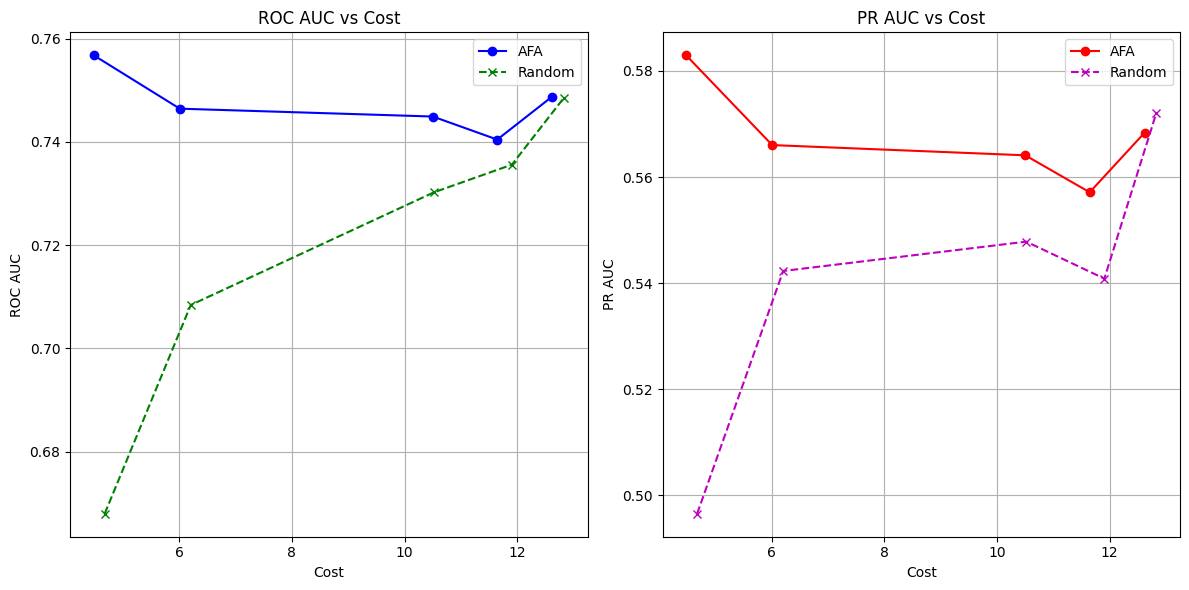

In [26]:
RANDOM_ROC_AUC = [0.6679639, 0.7084182, 0.73023814, 0.7485943, 0.73560685]
RANDOM_PR_AUC = [0.4965479, 0.542304, 0.5478352, 0.57216334, 0.54086417]
RANDOM_COST = [4.68, 6.2075, 10.52, 12.83, 11.90499997138977]

ROC_AUC = [0.75680137, 0.74492997, 0.7488037, 0.7464544, 0.7404645]
PR_AUC = [0.5829575, 0.56410503, 0.5683787, 0.56603134, 0.55713487]
COST = [4.485, 10.5025, 12.62, 6.0125, 11.645]

sorted_indices = np.argsort(COST)
sorted_COST = np.array(COST)[sorted_indices]
sorted_ROC_AUC = np.array(ROC_AUC)[sorted_indices]
sorted_PR_AUC = np.array(PR_AUC)[sorted_indices]

sorted_random_indices = np.argsort(RANDOM_COST)
sorted_RANDOM_COST = np.array(RANDOM_COST)[sorted_random_indices]
sorted_RANDOM_ROC_AUC = np.array(RANDOM_ROC_AUC)[sorted_random_indices]
sorted_RANDOM_PR_AUC = np.array(RANDOM_PR_AUC)[sorted_random_indices]

plt.figure(figsize=(12, 6))

# Plot ROC AUC vs COST
plt.subplot(1, 2, 1)
plt.plot(sorted_COST, sorted_ROC_AUC, marker='o', linestyle='-', color='b', label='AFA')
plt.plot(sorted_RANDOM_COST, sorted_RANDOM_ROC_AUC, marker='x', linestyle='--', color='g', label='Random')
plt.xlabel('Cost')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs Cost')
plt.legend()
plt.grid(True)

# Plot PR AUC vs COST
plt.subplot(1, 2, 2)
plt.plot(sorted_COST, sorted_PR_AUC, marker='o', linestyle='-', color='r', label='AFA')
plt.plot(sorted_RANDOM_COST, sorted_RANDOM_PR_AUC, marker='x', linestyle='--', color='m', label='Random')
plt.xlabel('Cost')
plt.ylabel('PR AUC')
plt.title('PR AUC vs Cost')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()